# Fáza 2 - predspracovanie údajov
# Autori: Matej Delinčák (50%), Martin Pirkovský (50%)

In [309]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import statsmodels.api as sm
from scipy.stats import mannwhitneyu
from scipy.stats import levene
from scipy.stats import kruskal
from scipy import stats
import matplotlib
import matplotlib.pylab as pylab
from sklearn.impute import KNNImputer

pd.set_option("display.max_columns", None)

## 1. Integrácia a čistenie dát (5b)

In [340]:
df_profiles = pd.read_csv("001/profiles.csv", sep='\t', parse_dates=['birthdate'])
df_profiles.drop('Unnamed: 0', axis=1, inplace=True)
df_labor = pd.read_csv("001/labor.csv", sep='\t')
df_labor.drop('Unnamed: 0', axis=1, inplace=True)
df = pd.merge(df_profiles,df_labor,on='name',how='outer')
df.head()

,sex,blood_group,job,residence,birthdate,ssn_x,current_location,race,name,erytrocyty,trombocyty,weight,hbver,ssn_y,relationship,er-cv,smoker,indicator,hematokrit,leukocyty,alp,hemoglobin,ast,alt,etytr
0,M,B-,Legal executive,"528 Allen Streets\r\nSolomonberg, NM 26158",1941-05-28,359-18-7254,"(Decimal('29.4768335'), Decimal('-42.485892'))",White,John Fletcher,5.73089,7.81439,74.67459,6.48334,359-18-7254,divoced,54.28887,N,1.0,6.68658,8.13103,71.53264,5.51496,72.78350,1.40153,8.26858
1,M,B-,Legal executive,"528 Allen Streets\r\nSolomonberg, NM 26158",1941-05-28,359-18-7254,"(Decimal('29.4768335'), Decimal('-42.485892'))",White,John Fletcher,7.00210,7.30681,64.56094,5.50101,359-18-7254,divoced,47.56065,no,1.0,8.14919,7.95707,53.26854,7.70607,70.42034,1.08658,8.76562
2,M,B-,Legal executive,"528 Allen Streets\r\nSolomonberg, NM 26158",1941-05-28,359-18-7254,"(Decimal('29.4768335'), Decimal('-42.485892'))",White,John Fletcher,5.87203,6.49993,102.55936,6.26296,359-18-7254,single,53.69510,yes,1.0,8.61871,8.80296,71.23821,5.67911,63.46493,0.94280,7.87057
3,M,B-,Legal executive,"528 Allen Streets\r\nSolomonberg, NM 26158",1941-05-28,359-18-7254,"(Decimal('29.4768335'), Decimal('-42.485892'))",White,John Fletcher,8.87748,7.57024,54.86142,7.31935,359-18-7254,married,53.84332,Y,1.0,6.05747,7.70553,64.00914,5.27333,76.12388,4.43028,6.29355
4,F,B+,Oceanographer,360 Rebecca Islands Suite 046\r\nEast Yolandav...,1992-08-29,476-75-8468,"(Decimal('-80.467120'), Decimal('-106.725872'))",White,Alexis Benjamin,5.51507,8.26611,109.48149,4.98513,476-75-8468,single,36.38495,no,1.0,8.41361,8.02251,86.54993,6.48007,84.46566,1.39040,7.38177


In [341]:
## vyhodili sme tieto stlpce: job, residence, birthdate(zamenit za age), ssn_x, current_location, name, ssn_y

df["age"] = datetime.datetime.now().year - pd.DatetimeIndex(df["birthdate"]).year
df = df.drop(columns=['residence', 'birthdate', 'ssn_x', 'current_location', 'name', 'ssn_y', 'job'])
df.drop_duplicates
df.head()

,sex,blood_group,race,erytrocyty,trombocyty,weight,hbver,relationship,er-cv,smoker,indicator,hematokrit,leukocyty,alp,hemoglobin,ast,alt,etytr,age
0,M,B-,White,5.73089,7.81439,74.67459,6.48334,divoced,54.28887,N,1.0,6.68658,8.13103,71.53264,5.51496,72.78350,1.40153,8.26858,80
1,M,B-,White,7.00210,7.30681,64.56094,5.50101,divoced,47.56065,no,1.0,8.14919,7.95707,53.26854,7.70607,70.42034,1.08658,8.76562,80
2,M,B-,White,5.87203,6.49993,102.55936,6.26296,single,53.69510,yes,1.0,8.61871,8.80296,71.23821,5.67911,63.46493,0.94280,7.87057,80
3,M,B-,White,8.87748,7.57024,54.86142,7.31935,married,53.84332,Y,1.0,6.05747,7.70553,64.00914,5.27333,76.12388,4.43028,6.29355,80
4,F,B+,White,5.51507,8.26611,109.48149,4.98513,single,36.38495,no,1.0,8.41361,8.02251,86.54993,6.48007,84.46566,1.39040,7.38177,29


## Predspracovanie jednotlivych atributov
### Atribut sex

In [342]:
print(len((df[df['sex'].isnull()])))

0


In [343]:
def sanitize_sex(sex):
    return 1 if sex == "M" else 0

In [344]:
df['sex'] = df['sex'].map(lambda x: sanitize_sex(x))

In [345]:
df['sex'].unique()

array([1, 0], dtype=int64)

Atribút sex nemá žiadne null hodnoty, a teda nepotrebujeme riešiť chybajúce hodnoty.
Zamenili sme hodnoty 'M' za 1 a 'F' za 0. Tieto hodnoty nebolo potrebné upravovať,
nakoľko všetky boli v tvare 'M' alebo 'F'.

### Atribut blood_group

In [346]:
print(len((df[df['blood_group'].isnull()])))

0


In [347]:
def sanitize_blood_group(blood_group):
    if blood_group == 'B-':
        return 0
    elif blood_group == 'B+':
        return 1
    elif blood_group == 'AB+':
        return 2
    elif blood_group == 'O+':
        return 3
    elif blood_group == 'AB-':
        return 4
    elif blood_group == 'A-':
        return 5
    elif blood_group == 'O-':
        return 6
    elif blood_group == 'A+':
        return 7
    return blood_group

In [348]:
df['blood_group'] = df['blood_group'].map(lambda x: sanitize_blood_group(x))

In [349]:
df['blood_group'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

### Atribut race

In [350]:
print(len((df[df['race'].isnull()])))

0


In [351]:
def sanitize_race(race):
    if race == 'black' or race == 'blsck' or race == 'Black':
        return 0
    elif race == 'white' or race == 'White':
        return 1
    elif race == 'Indian':
        return 2
    elif race == 'Asian':
        return 3
    elif race == 'Hawaiian':
        return 4
    return race

In [352]:
df['race'] = df['race'].map(lambda race: sanitize_race(race))

In [353]:
df['race'].unique()

array([1, 2, 0, 3, 4], dtype=int64)

### Atribut erytrocyty

In [354]:
print(len((df[df['erytrocyty'].isnull()])))

31


In [355]:
df.dropna(subset = ["erytrocyty"], inplace=True)
print(len((df[df['erytrocyty'].isnull()])))

0


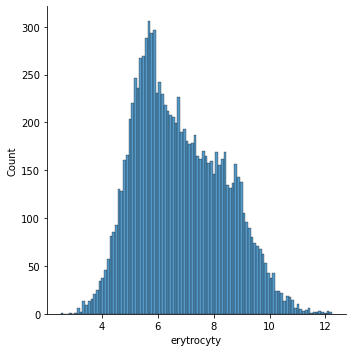

In [356]:
sns.displot(df['erytrocyty'],bins=100)

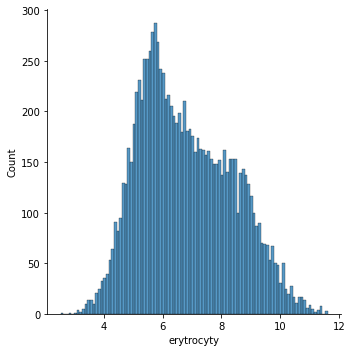

In [357]:
def identify_outliers(x):
    lower_ = x.quantile(0.25) - 1.5 * stats.iqr(x)
    upper_ = x.quantile(0.75) + 1.5 * stats.iqr(x)

    return x[(x > upper_) | (x < lower_)]

df_merged_out = identify_outliers(df["erytrocyty"])
df = df.drop(df_merged_out.index)
sns.displot(df['erytrocyty'],bins=100)

V atribute eryrocyty sme null hodnoty vyhodili a outlierov sme vyhodili takisto.

#### Atribut trombocyty

In [358]:
print(len((df[df['trombocyty'].isnull()])))

33


In [359]:
df['trombocyty'].fillna(df['trombocyty'].mean(), inplace=True)
print(len((df[df['trombocyty'].isnull()])))

0


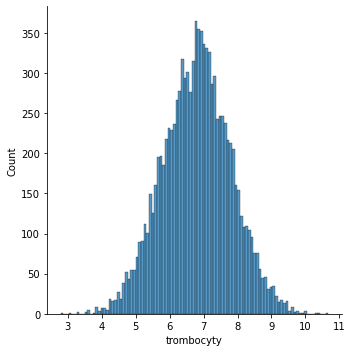

In [360]:
sns.displot(df['trombocyty'],bins=100)

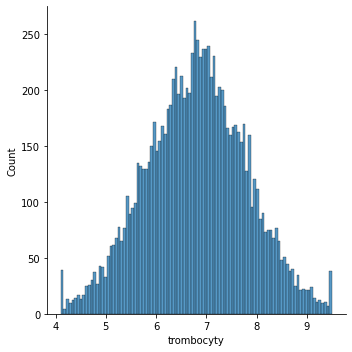

In [361]:
lower = df['trombocyty'].quantile(0.25) - 1.5 * stats.iqr(df['trombocyty'])
upper = df['trombocyty'].quantile(0.75) + 1.5 * stats.iqr(df['trombocyty'])

df["trombocyty"] = np.where(df["trombocyty"] > upper, upper, df['trombocyty'])
df["trombocyty"] = np.where(df["trombocyty"] < lower, lower, df['trombocyty'])
sns.displot(df['trombocyty'],bins=100)

V atribute trombocyty sme nahradili null hodnoty a outliers hranicnymi hodnotami rozdelenia

#### Atribut weight

In [362]:
df["weight"] = np.where(df["weight"] < 1, np.nan, df['weight'])
df.dropna(subset = ["weight"], inplace=True)
print(len((df[df['weight'].isnull()])))

0


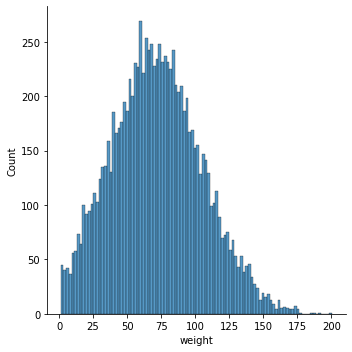

In [363]:
sns.displot(df['weight'],bins=100)

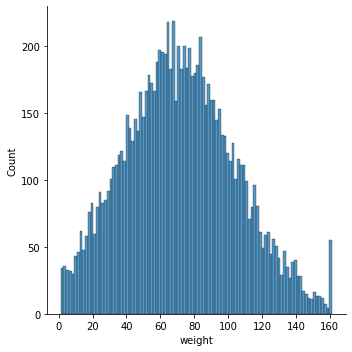

In [364]:
lower = df['weight'].quantile(0.25) - 1.5 * stats.iqr(df['weight'])
upper = df['weight'].quantile(0.75) + 1.5 * stats.iqr(df['weight'])

df["weight"] = np.where(df["weight"] > upper, upper, df['weight'])
df["weight"] = np.where(df["weight"] < lower, lower, df['weight'])
sns.displot(df['weight'],bins=100)

V atribute weight sme odstránili nezmyselné hodnoty (vahy menšie ako 1kg)
a nahradili sme za medián váh.

#### Atribut relation

In [378]:
print(len((df[df['relationship'].isnull()])))

0


In [379]:
df.dropna(subset = ["relationship"], inplace=True)
print(len((df[df['relationship'].isnull()])))

0


In [380]:
def sanitize_relation(relationship):
    if relationship == 'divoced' or relationship == 'divorced' :
        return 0
    elif relationship == 'single':
        return 1
    elif relationship == 'married':
        return 2
    elif relationship == 'widowed':
        return 3
    elif relationship == 'separated':
        return 4
    elif relationship == 'nop':
        return 5
    return relationship

In [381]:
df['relationship'] = df['relationship'].map(lambda relation: sanitize_relation(relation))

In [382]:
df['relationship'].unique()

array([0, 1, 2, 3, 4, 5], dtype=int64)

V atribute relationship sme vymazali null hodnoty a zvysne nahradili integer hodnotami (encoding)

#### Atribut smoker

In [383]:
print(len((df[df['smoker'].isnull()])))

0


In [384]:
df.dropna(subset = ["smoker"], inplace=True)
print(len((df[df['smoker'].isnull()])))

0


In [385]:
def sanitize_smoker(smoker):
    if smoker == 'N' or smoker == 'no' :
        return 0
    elif smoker == 'Y' or smoker == 'yes':
        return 1
    return smoker

In [386]:
df['smoker'] = df['smoker'].map(lambda smoker: sanitize_smoker(smoker))

In [387]:
df['smoker'].unique()

array([0, 1], dtype=int64)

V atribute smoker sme vymazali null hodnoty a zvysne nahradili integer hodnotami (encoding).

#### Atribut hbver

In [ ]:
print(len((df[df['hbver'].isnull()])))

In [ ]:
imputer = KNNImputer(n_neighbors=5)
df = pd.DataFrame(imputer.fit_transform(df), columns = df.columns)
print(len((df[df['hbver'].isnull()])))

In [ ]:
sns.displot(df['hbver'],bins=100)

In [ ]:
lower = df['hbver'].quantile(0.25) - 1.5 * stats.iqr(df['hbver'])
upper = df['hbver'].quantile(0.75) + 1.5 * stats.iqr(df['hbver'])

df["hbver"] = np.where(df["hbver"] > upper, upper, df['hbver'])
df["hbver"] = np.where(df["hbver"] < lower, lower, df['hbver'])
sns.displot(df['hbver'],bins=100)

V atribute hbver a v podstate celom datasete sme nahradili null hodnoty pomocou KNN algoritmu, cize dalej null hodnoty uz nebudeme riesit. A outlierov sme zase ustrihli a nahradili krajnymi hodnotami.

#### Atribut er-cv

In [393]:
print(len((df[df['er-cv'].isnull()])))

0


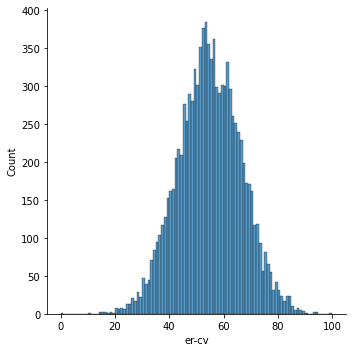

In [394]:
sns.displot(df['er-cv'],bins=100)

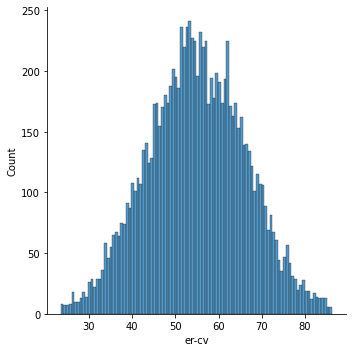

In [395]:
def identify_outliers(x):
    lower_ = x.quantile(0.25) - 1.5 * stats.iqr(x)
    upper_ = x.quantile(0.75) + 1.5 * stats.iqr(x)

    return x[(x > upper_) | (x < lower_)]

df_merged_out = identify_outliers(df["er-cv"])
df = df.drop(df_merged_out.index)
sns.displot(df['er-cv'],bins=100)

V atribute er-cv sme uz teda nepotrebovali odstranovat null lebo knn. Outlierov sme odstranili pre zmenu.


#### Atribut hematokrit

In [409]:
print(len((df[df['hematokrit'].isnull()])))

0


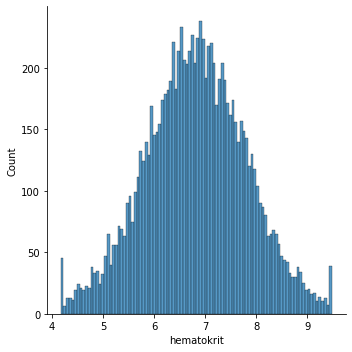

In [410]:
sns.displot(df['hematokrit'],bins=100)

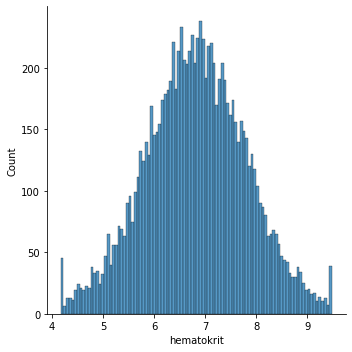

In [411]:
lower = df['hematokrit'].quantile(0.25) - 1.5 * stats.iqr(df['hematokrit'])
upper = df['hematokrit'].quantile(0.75) + 1.5 * stats.iqr(df['hematokrit'])

df["hematokrit"] = np.where(df["hematokrit"] > upper, upper, df['hematokrit'])
df["hematokrit"] = np.where(df["hematokrit"] < lower, lower, df['hematokrit'])
sns.displot(df['hematokrit'],bins=100)

V atribute hematokrit sme uz nepotrebovali odstranovat null lebo KNN. Outlierov sme nahradili krajnými hodnotami.

#### Atribut leukocyty

In [412]:
print(len((df[df['leukocyty'].isnull()])))

0


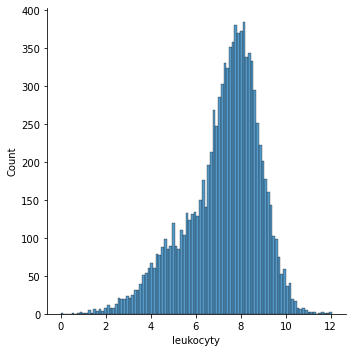

In [413]:
sns.displot(df['leukocyty'],bins=100)

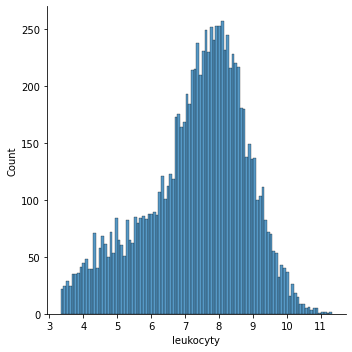

In [414]:
def identify_outliers(x):
    lower_ = x.quantile(0.25) - 1.5 * stats.iqr(x)
    upper_ = x.quantile(0.75) + 1.5 * stats.iqr(x)

    return x[(x > upper_) | (x < lower_)]

df_merged_out = identify_outliers(df["leukocyty"])
df = df.drop(df_merged_out.index)
sns.displot(df['leukocyty'],bins=100)

V atribute leukocyty sme uz teda nepotrebovali odstranovat null lebo knn. Outlierov sme odstranili pre zmenu.

#### Atribut alp

In [415]:
print(len((df[df['alp'].isnull()])))

0


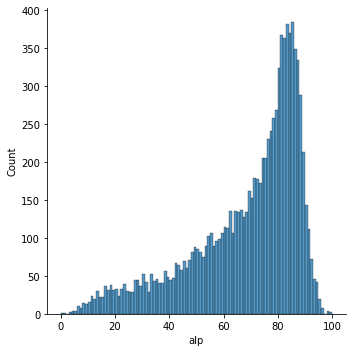

In [416]:
sns.displot(df['alp'],bins=100)

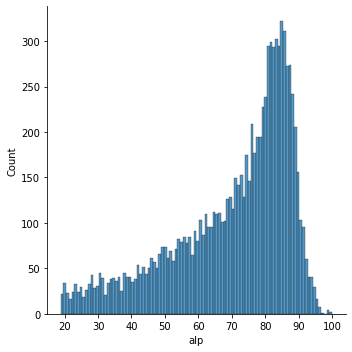

In [417]:
def identify_outliers(x):
    lower_ = x.quantile(0.25) - 1.5 * stats.iqr(x)
    upper_ = x.quantile(0.75) + 1.5 * stats.iqr(x)

    return x[(x > upper_) | (x < lower_)]

df_merged_out = identify_outliers(df["alp"])
df = df.drop(df_merged_out.index)
sns.displot(df['alp'],bins=100)

V atribute alp sme uz teda nepotrebovali odstranovat null lebo knn. Outlierov sme odstranili pre zmenu.


#### Atribut hemoglobin

In [418]:
print(len((df[df['hemoglobin'].isnull()])))

0


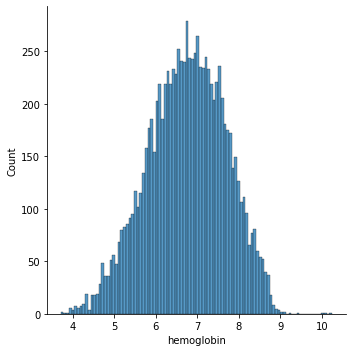

In [419]:
sns.displot(df['hemoglobin'],bins=100)

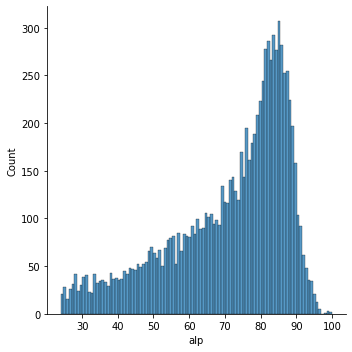

In [420]:
def identify_outliers(x):
    lower_ = x.quantile(0.25) - 1.5 * stats.iqr(x)
    upper_ = x.quantile(0.75) + 1.5 * stats.iqr(x)

    return x[(x > upper_) | (x < lower_)]

df_merged_out = identify_outliers(df["alp"])
df = df.drop(df_merged_out.index)
sns.displot(df['alp'],bins=100)

V atribute hemoglobin sme uz teda nepotrebovali odstranovat null lebo knn. Outlierov sme odstranili pre zmenu.

#### Atribut ast

In [421]:
print(len((df[df['ast'].isnull()])))

0


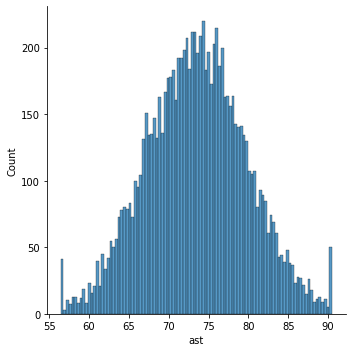

In [422]:
sns.displot(df['ast'],bins=100)

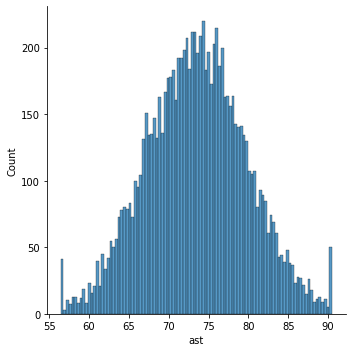

In [423]:
lower = df['ast'].quantile(0.25) - 1.5 * stats.iqr(df['ast'])
upper = df['ast'].quantile(0.75) + 1.5 * stats.iqr(df['ast'])

df["ast"] = np.where(df["ast"] > upper, upper, df['ast'])
df["ast"] = np.where(df["ast"] < lower, lower, df['ast'])
sns.displot(df['ast'],bins=100)

V atribute ast sme uz nepotrebovali odstranovat null lebo KNN. Outlierov sme nahradili krajnými hodnotami.

#### Atribut alt

In [424]:
print(len((df[df['alt'].isnull()])))

0


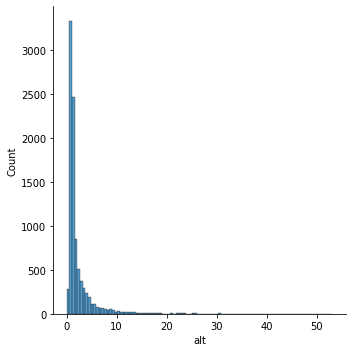

In [425]:
sns.displot(df['alt'],bins=100)

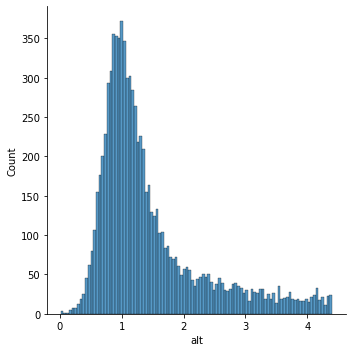

In [426]:
def identify_outliers(x):
    lower_ = x.quantile(0.25) - 1.5 * stats.iqr(x)
    upper_ = x.quantile(0.75) + 1.5 * stats.iqr(x)

    return x[(x > upper_) | (x < lower_)]

df_merged_out = identify_outliers(df["alt"])
df = df.drop(df_merged_out.index)
sns.displot(df['alt'],bins=100)

V atribute alt sme uz teda nepotrebovali odstranovat null lebo knn. Outlierov sme odstranili pre zmenu.

#### Atribut etytr

In [427]:
print(len((df[df['etytr'].isnull()])))

0


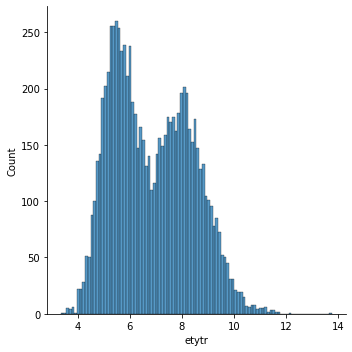

In [428]:
sns.displot(df['etytr'],bins=100)

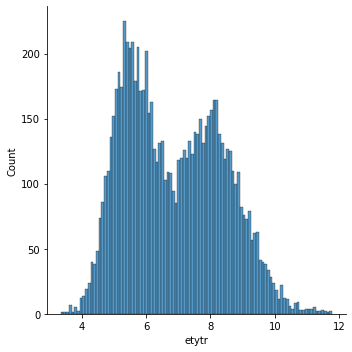

In [429]:
def identify_outliers(x):
    lower_ = x.quantile(0.25) - 1.5 * stats.iqr(x)
    upper_ = x.quantile(0.75) + 1.5 * stats.iqr(x)

    return x[(x > upper_) | (x < lower_)]

df_merged_out = identify_outliers(df["etytr"])
df = df.drop(df_merged_out.index)
sns.displot(df['etytr'],bins=100)

V atribute etytr sme uz teda nepotrebovali odstranovat null lebo knn. Outlierov sme odstranili pre zmenu.

#### Atribut ast

In [430]:
print(len((df[df['age'].isnull()])))

0


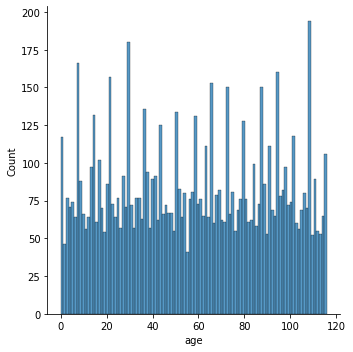

In [431]:
sns.displot(df['age'],bins=100)

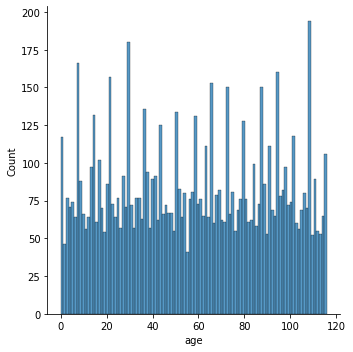

In [432]:
lower = df['age'].quantile(0.25) - 1.5 * stats.iqr(df['age'])
upper = df['age'].quantile(0.75) + 1.5 * stats.iqr(df['age'])

df["age"] = np.where(df["age"] > upper, upper, df['age'])
df["age"] = np.where(df["age"] < lower, lower, df['age'])
sns.displot(df['age'],bins=100)

V atribute age sme uz nepotrebovali odstranovat null lebo KNN. Outlierov sme nahradili krajnými hodnotami.